In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import operator

In [2]:
class fp_tree_node:
    def __init__(self,item_name,frequency,parent):
        self.parent=parent
        self.item_name=item_name
        self.frequency=frequency
        self.child_node=defaultdict()
        self.next_node=None
        
    def update_item_frequency(self,frequency):
        self.frequency+=frequency
        
    def display_fp_tree(self,index=1):
        print('  '*index + f' Item : {self.item_name}  Frequency: {self.frequency}  Parent : {self.parent}')
        for names,child in self.child_node.items():
            child.display_fp_tree(index+1)

In [3]:
class build_fp_tree:
    def __init__(self,transactions,min_support_count):
        self.transactions=transactions
        self.min_support=min_support_count
        self.header_table=defaultdict()
        self.fp_root=None
    
    def is_frequent(self,frequency):
        if(frequency < self.min_support):
            return False
        else:
            return True
    
    
    def get_frequent_itemsets(self):
        return set(self.header_table.keys())
    
    
    def display_header_table(self):
        print(self.header_table.items())
    
    
    def get_ordered_itemsets(self,itemsets):
        sorted_items=sorted(itemsets.items(), key=operator.itemgetter(1), reverse=True)
        items=[item[0] for item in sorted_items]
        return items
    
    def update_fp_tree(self,tree_node,ordered_items,occurance_cnt):
        if ordered_items[0] in tree_node.child_node:
            tree_node.child_node[ordered_items[0]].update_item_frequency(occurance_cnt)
        else:
            
            tree_node.child_node[ordered_items[0]]=fp_tree_node(ordered_items[0],occurance_cnt,tree_node)
            
            if not self.header_table[ordered_items[0]][1]:
                self.header_table[ordered_items[0]][1]=tree_node.child_node[ordered_items[0]]
            else:
                #update headertable
                target_node=tree_node.child_node[ordered_items[0]]
                start_node=self.header_table[ordered_items[0]][1]
                
                while(start_node.next_node != None):
                    start_node=start_node.next_node
                start_node.next_node=target_node
        
        if(len(ordered_items)>1):
            self.update_fp_tree(tree_node.child_node[ordered_items[0]],ordered_items[1::],occurance_cnt)
    
    def remove_infrequent_items(self):
        for item in list(self.header_table.keys()):
            if(self.header_table[item] < self.min_support):
                del self.header_table[item]
   

    def create_tree(self):
        for transaction in self.transactions:
            for item in transaction:
                self.header_table[item]=self.header_table.get(item,0) + self.transactions[transaction]
        
        self.remove_infrequent_items()
        
        frequent_items=self.get_frequent_itemsets()
        if(len(frequent_items)==0):
            return None,None
        
        for keys in self.header_table:
            self.header_table[keys]= [self.header_table[keys],None]
        
        self.fp_root=fp_tree_node('Φ',1,None)
        
        for transaction,transaction_occurances in self.transactions.items():
            temp_transactions=defaultdict()
            
            for item in transaction:
                if item in frequent_items:
                    temp_transactions[item]=self.header_table[item][0]
            
            if len(temp_transactions)>0:
                ordered_items=self.get_ordered_itemsets(temp_transactions)
                self.update_fp_tree(self.fp_root,ordered_items,transaction_occurances)
        return self.fp_root,self.header_table
    

In [4]:
class MineFPTree:
    def __init__(self,min_support):
        self.min_support=min_support
        self.frequent_itemset_list=list()
        
    def get_ordered_itemsets(self,itemsets):
        if(itemsets is not None):
            sorted_items=sorted(itemsets,key=lambda key : itemsets[key][0],reverse=True)
        else:
            return []
        if len(sorted_items)>0:
            return sorted_items
        else:
            return []
        #return [v[0] for v in sorted(itemsets.items(), key=lambda p: p[1][0])]
    
    def find_root(self,first_node,suffix_path):
        if(first_node.parent is not None):
            
            suffix_path.append(first_node.item_name)
            
            self.find_root(first_node.parent,suffix_path)
    
    def find_suffix_path(self,item_name,node):

        conditional_patterns={}
        
        while(node is not None):
            suffix_path=list()
            self.find_root(node,suffix_path)
            
            if(len(suffix_path)>1):
                conditional_patterns[frozenset(suffix_path[1:])]=node.frequency
            node=node.next_node
        return conditional_patterns
    
    def find_frequent_itemsets(self,start_node,header_tab,suffix_set):
       
        sorted_items=self.get_ordered_itemsets(header_tab)
        for base in sorted_items:
            temp_frequent_set=suffix_set.copy()
            temp_frequent_set.add(base)
            
            self.frequent_itemset_list.append(temp_frequent_set)
            
            conditional_base=self.find_suffix_path(base,header_tab[base][1])
            
            fp_tree_obj=build_fp_tree(conditional_base,self.min_support)
            
            temp_tree,temp_header_table=fp_tree_obj.create_tree()
  
            if(temp_header_table is not None):
                self.find_frequent_itemsets(temp_tree,temp_header_table,temp_frequent_set)

In [8]:
def load_transaction(data_path,type_=None):
        transactions=[]
        with open(data_path,'r') as data_file:
            for lines in tqdm(data_file):
                if(type_==2):
                    transactions_list=list(lines.strip('-2\n').split('-1'))
                else:
                    transactions_list=list(lines.strip().split())
                
                transactions_list=[int(x) for x in transactions_list if x is not ' ']

                transactions_list=list(np.unique(transactions_list))
                transactions_list.sort()
                transactions.append(transactions_list)
    
        transactions_dict=defaultdict()
        for transaction in transactions:
            transactions_dict[frozenset(transaction)]=1
        return transactions_dict

In [9]:
transaction_dict=load_transaction('bwv_data_2.txt',2)

77512it [00:00, 82369.25it/s]


In [20]:
thresh=0.06
fp_tree_object=build_fp_tree(transaction_dict,len(transaction_dict)*thresh)
fp_tree_root,header_table=fp_tree_object.create_tree()

In [19]:
mine_tree=MineFPTree(len(transaction_dict)*thresh)
mine_tree.find_frequent_itemsets(fp_tree_root,header_table,set([]))
mine_tree.frequent_itemset_list

[{55267}, {55323}]

In [21]:
min_thresh=[0.001,0.01,0.05,0.1,0.5,0.95,1]
fp_top_down=[]
from time import time
for thresh in tqdm(min_thresh):
    start=time()
    fp_tree_object=build_fp_tree(transaction_dict,thresh*len(transaction_dict))
    fp_tree_root,header_table=fp_tree_object.create_tree()
    mine_tree=MineFPTree(thresh*len(transaction_dict))
    mine_tree.find_frequent_itemsets(fp_tree_root,header_table,set([]))
    end=time()
    fp_top_down.append(end-start)

100%|████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.43s/it]


In [25]:
library_fp=[2.727998733520508,
 0.9069375991821289,
 0.6270380020141602,
 0.6419644355773926,
 0.6100003719329834,
 0.6520016193389893,
 0.6179986000061035]

In [24]:
fp_top_down

[8.054324626922607,
 1.396963119506836,
 0.14299821853637695,
 0.10703396797180176,
 0.09696149826049805,
 0.09800386428833008,
 0.09799718856811523]

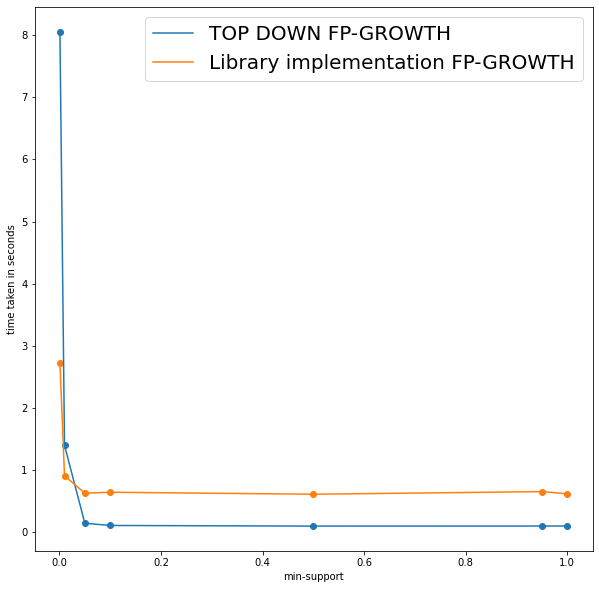

In [26]:
min_thresh=[0.001,0.01,0.05,0.1,0.5,0.95,1]

import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))


plt.plot(min_thresh,fp_top_down,label='TOP DOWN FP-GROWTH')
plt.scatter(min_thresh,fp_top_down)

plt.plot(min_thresh,library_fp,label='Library implementation FP-GROWTH')
plt.scatter(min_thresh,library_fp)

plt.xlabel('min-support')
plt.ylabel('time taken in seconds')

plt.legend(fontsize=20,loc="upper right")
plt.show()